## Tratamento dos dados

#### Importação das bibliotecas

In [1]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral
from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [2]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['spanish_primera_division.csv',
 'dutch_eredivisie.csv',
 'portugese_liga_nos.csv',
 'french_ligue_1.csv',
 'italian_serie_a.csv',
 'russian_premier_liga.csv',
 'english_premier_league.csv',
 'english_championship.csv',
 'german_bundesliga_1.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [34]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    dir = "./data/transfers_master/data/"+ year + "/dutch_eredivisie.csv"
    data = pd.read_csv(dir)

    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[1:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            
            # Concatenação dos dados
            data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [4]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
data

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.00,Eredivisie,1992,1992/1993
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,Summer,0.00,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...
271,1.FC Nuremberg,Percy Olivares,24.0,Left-Back,Sport. Cristal,Free transfer,out,Winter,0.00,1 Bundesliga,1992,1992/1993
272,1. FC Köln,Andrzej Kobylanski,22.0,Left Midfield,Siarka T.,£270Th.,in,Winter,0.27,1 Bundesliga,1992,1992/1993
273,1.FC Kaiserslautern,Bernhard Winkler,26.0,Centre-Forward,SC Fortuna Köln,Loan,out,Winter,0.00,1 Bundesliga,1992,1992/1993
274,SG Dynamo Dresden,Nikica Maglica,27.0,Forward,NK Zagreb,?,in,Winter,NaN,1 Bundesliga,1992,1992/1993


In [5]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [6]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

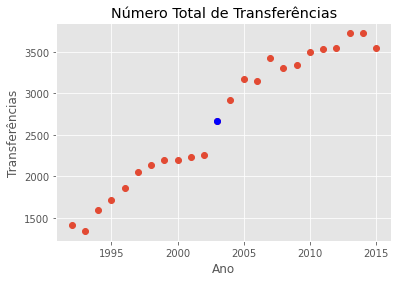

In [7]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era")

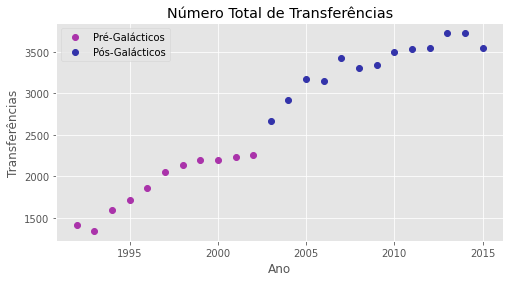

In [8]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [9]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [10]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
data_in

,index,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,transfer_period,fee_cleaned,league_name,year,season
0,0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC Kerkrade,?,in,Summer,NaN,Eredivisie,1992,1992/1993
1,1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,Summer,NaN,Eredivisie,1992,1992/1993
2,2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,Summer,NaN,Eredivisie,1992,1992/1993
3,3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,Summer,0.00,Eredivisie,1992,1992/1993
4,8,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,Summer,NaN,Eredivisie,1992,1992/1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64570,562,Hamburger SV,Josip Drmic,23.0,Centre-Forward,Bor. M'gladbach,Loan fee:£1.08m,in,Winter,1.08,1 Bundesliga,2015,2015/2016
64571,563,Hamburger SV,Nabil Bahoui,24.0,Left Winger,Ahli,Free transfer,in,Winter,0.00,1 Bundesliga,2015,2015/2016
64572,564,Hamburger SV,Dren Feka,18.0,Defensive Midfield,Hamburger SV,-,in,Winter,0.00,1 Bundesliga,2015,2015/2016
64573,568,FC Ingolstadt 04,Darío Lezcano,25.0,Centre-Forward,FC Luzern,£2.25m,in,Winter,2.25,1 Bundesliga,2015,2015/2016


In [11]:
data_in["year"].value_counts()

2013    3726
2014    3724
2012    3554
2015    3547
2011    3541
2010    3494
2007    3428
2009    3343
2008    3305
2005    3175
2006    3154
2004    2926
2003    2663
2002    2256
2001    2240
2000    2194
1999    2193
1998    2137
1997    2051
1996    1857
1995    1718
1994    1593
1992    1413
1993    1343
Name: year, dtype: int64

In [12]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [13]:
g2 = Graph(directed=True) # dirigido
g2.vp['name'] = g2.new_vp('object')
g2.vp['league'] = g2.new_vp('object')

In [14]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time1))
        g2.vp['name'][v_time] = time1
        g2.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        g2.add_vertex()
        v_time = g2.vertex(times.index(time2))
        g2.vp['name'][v_time] = time2
        g2.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if g2.edge(index1, index2) == None:
        g2.add_edge(index1, index2)

In [15]:
stats.remove_self_loops(g2)
m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo3.net.gz')

In [16]:
data_in["league_name"].value_counts()

Championship      12342
Eredivisie        11216
Premier League     9652
Serie A            7532
Liga Nos           7382
Ligue 1            6365
1 Bundesliga       5163
Premier Liga       4923
Name: league_name, dtype: int64

In [17]:
g2 = load_gt('exemplo3.net.gz')

g2.vp['color'] = g2.new_vp('object')

for v in g2.vertices():
    if g2.vp['league'][v] == "Premier League":
        g2.vp['color'][v] = 0x0000ff
        
    if g2.vp['league'][v] == "Eredivisie":
        g2.vp['color'][v] = 0x00ff00
        
    if g2.vp['league'][v] == "Championship":
        g2.vp['color'][v] = 0x0000f0
        
    if g2.vp['league'][v] == "Serie A":
        g2.vp['color'][v] = 0xff00ff
        
    if g2.vp['league'][v] == "Liga Nos":
        g2.vp['color'][v] = 0xff0000
        
    if g2.vp['league'][v] == "Ligue 1":
        g2.vp['color'][v] = 0xffff00
        
    if g2.vp['league'][v] == "1 Bundesliga":
        g2.vp['color'][v] = 0x1100ff
        
    if g2.vp['league'][v] == "Premier Liga":
        g2.vp['color'][v] = 0x00ffff

m = draw_gt.sfdp_layout(g2)
move_gt(g2, m)
save_gt(g2, 'exemplo4.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [18]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [19]:
centro_periferia(g2, "core")

In [20]:
df = pd.DataFrame({k: list(v) for k, v in g2.vp.items()})
df.head()

,id,name,league,_x,_y,color,core
0,0,Ajax Amsterdam,Eredivisie,-1.228343,-0.838036,65280,1.0
1,1,Newell's,Eredivisie,-1.302304,-0.783255,65280,0.0
2,2,SC Heerenveen,Eredivisie,-1.230150,-0.870253,65280,1.0
3,3,Boca Juniors,Eredivisie,-1.255578,-0.768044,65280,0.0
4,4,Figueirense FC,Eredivisie,-1.154484,-0.768528,65280,0.0


In [21]:
df["league"].value_counts()

Liga Nos          609
Premier Liga      357
Championship      351
Serie A           348
Eredivisie        322
Ligue 1           285
Premier League    246
1 Bundesliga      225
Name: league, dtype: int64

In [22]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5)
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5)
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5)
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5)
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5)
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5)
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5)
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5)
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

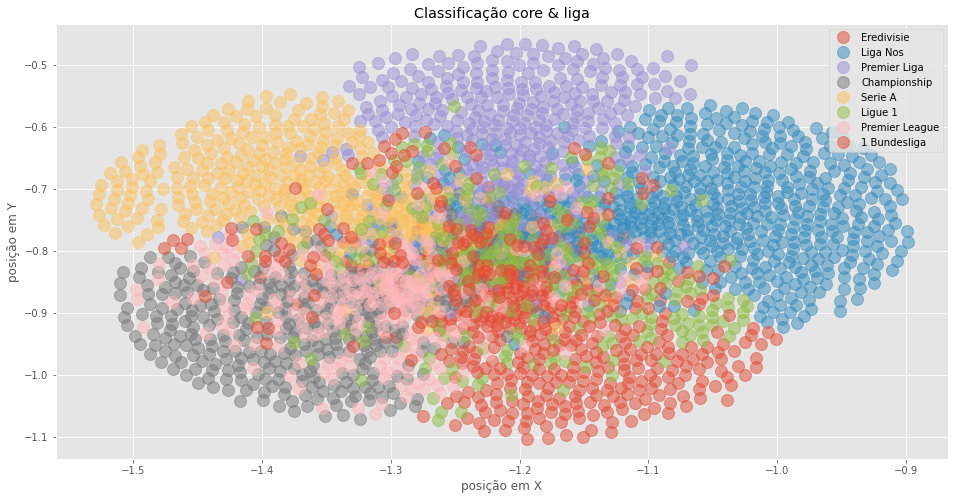

In [23]:
plot_cp(df)

In [64]:
def loading_champions_data(DATA_DIR, year, end):
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        data = pd.concat([data, pd.read_csv(dir)])
     
    return(data)

In [71]:
DATA_DIR = './data/champions_league'
YEAR = 1992

data = loading_champions_data(DATA_DIR, YEAR, 2015)
data

,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,NaN,Prelim. Round | Leg 1,NaN,(Wed) 19 Aug 1992 (W33),Olimpija Ljubljana › SVN (1),3-0,0-0,FC Norma Tallinn › EST (1),NaN,NaN,NaN,NaN
1,NaN,Prelim. Round | Leg 1,NaN,(Wed) 19 Aug 1992 (W33),KI Klaksvik › FRO (1),1-3,0-0,Skonto › LVA (1),NaN,NaN,NaN,NaN
2,NaN,Prelim. Round | Leg 1,NaN,(Wed) 19 Aug 1992 (W33),Valletta › MLT (1),1-2,0-0,Maccabi Tel Aviv › ISR (1),NaN,NaN,NaN,NaN
3,NaN,Prelim. Round | Leg 1,NaN,(Wed) 19 Aug 1992 (W33),Shelbourne › IRL (1),0-0,0-0,Tavriya Simferopol › UKR (1),NaN,NaN,NaN,NaN
4,NaN,Prelim. Round | Leg 2,NaN,(Wed) 2 Sep 1992 (W35),FC Norma Tallinn › EST (2),0-2,0-0,Olimpija Ljubljana › SVN (2),0-5 (agg.),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
212,Knockout,Semifinals | Leg 1,NaN,(Tue) 26 Apr 2016 (W17),Manchester City FC › ENG (11),0-0,0-0,Real Madrid CF › ESP (11),NaN,NaN,NaN,NaN
213,Knockout,Semifinals | Leg 1,NaN,(Wed) 27 Apr 2016 (W17),Atletico Madrid › ESP (11),1-0,1-0,Bayern München › GER (11),NaN,NaN,NaN,NaN
214,Knockout,Semifinals | Leg 2,NaN,(Tue) 3 May 2016 (W18),Bayern München › GER (12),2-1,1-0,Atletico Madrid › ESP (12),(a) 2-2 (agg.),NaN,NaN,Away Goals (2)
215,Knockout,Semifinals | Leg 2,NaN,(Wed) 4 May 2016 (W18),Real Madrid CF › ESP (12),1-0,1-0,Manchester City FC › ENG (12),1-0 (agg.),NaN,NaN,NaN
